In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timm import create_model  # Timm 라이브러리 사용
from torchvision.datasets import ImageNet
import matplotlib.pyplot as plt
import random
import torch.quantization
import copy
import os
import time
from torch.nn.quantized.dynamic import Linear as DynamicQuantizedLinear

import quantize_extension 

torch.cuda.empty_cache()

### Device : CUDA 설정 ###

In [2]:
USE_CUDA = torch.cuda.is_available()  # GPU를 사용할 수 있는지 확인
device = torch.device("cuda" if USE_CUDA else "cpu")  # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)
#device = "cpu"
random.seed(777)
torch.manual_seed(777)  
if device == 'cuda':
    torch.cuda.manual_seed_all(777)


다음 기기로 학습합니다: cuda


### 양자화 시간 측정 ###

In [3]:
# 대칭 양자화를 수행하는 함수
def quantize_symmetric(weight, num_bits=8):
    qmin = -128
    qmax = 127
    
    max_val = weight.abs().max()
    scale = max_val / qmax if max_val != 0 else 1.0
    
    weight = torch.clamp((weight / scale).round(), qmin, qmax).to(torch.int8)
    
    return weight, scale


@torch.no_grad()
def quantize_weight_per_tensor_absmax(w, n_bits=8):
    # w: (out_features, in_features)
    scales = w.abs().max()
    q_max = 127
    scales.clamp_(min=1e-5).div_(q_max)
    w.div_(scales)

    return w.type(torch.int8), scales

# 가중치를 디양자화하는 함수
def dequantize_symmetric(quantized_weight, scale):
    return quantized_weight.float() * scale


x = torch.rand(1024, 1024).to(device).type(torch.float32)

# 이벤트 생성
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

elapsed_time_ms = 0.0
num_runs = 50

for i in range(num_runs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    # 시작 이벤트 기록
    start_event.record()

    x_int8, x_scale = quantize_extension.quantize_symmetric_cuda(x, 8)

    # 종료 이벤트 기록
    end_event.record()

    # 이벤트 완료까지 대기
    torch.cuda.synchronize()

    # 이벤트 사이 시간 측정 (밀리초 단위)
    elapsed_time_ms += start_event.elapsed_time(end_event)

elapsed_time_ms /= num_runs
print(f"Custom Kernel Quantization time: {elapsed_time_ms:.3f} ms")


elapsed_time_ms = 0.0

for i in range(num_runs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    
    #torch.backends.cuda.matmul.allow_tf32 = True
    start_event.record()
    y_int8, y_scale = quantize_symmetric(x, 8)
    end_event.record()

    # 이벤트 완료까지 대기
    torch.cuda.synchronize()

    # 이벤트 사이 시간 측정 (밀리초 단위)
    elapsed_time_ms += start_event.elapsed_time(end_event)

elapsed_time_ms /= num_runs
print(f"Pytorch Quantization time: {elapsed_time_ms:.3f} ms")


print(torch.allclose(x_int8, y_int8, atol=1e-0))
print(x_int8)
print(y_int8)


Custom Kernel Quantization time: 0.265 ms
Pytorch Quantization time: 1.757 ms
True
tensor([[ 10,  62,  51,  ...,  42,  44,  92],
        [ 79, 122,  16,  ..., 126,  80,  93],
        [ 59, 117, 115,  ...,  21,  13,  69],
        ...,
        [105,  53,  89,  ..., 127,  70,  84],
        [ 61,   7,  40,  ...,   9,  28,  13],
        [ 69, 121, 106,  ...,  41,  94, 115]], device='cuda:0',
       dtype=torch.int8)
tensor([[ 10,  62,  51,  ...,  42,  44,  92],
        [ 79, 122,  16,  ..., 126,  80,  93],
        [ 59, 117, 115,  ...,  21,  13,  69],
        ...,
        [105,  53,  89,  ..., 127,  70,  84],
        [ 61,   7,  40,  ...,   9,  28,  13],
        [ 69, 121, 106,  ...,  41,  94, 115]], device='cuda:0',
       dtype=torch.int8)


### 행렬곱셈 시간 측정 ###

In [4]:
# x = torch.rand(1024, 1024).to(device).type(torch.float32).to(device)
# y = torch.rand(1024, 1024).to(device).type(torch.float32).to(device)

x = torch.rand(3000, 3000).to(device).type(torch.float32).to(device)
y = torch.rand(3000, 3000).to(device).type(torch.float32).to(device)

# x = torch.rand(5000, 5000).to(device).type(torch.float32).to(device)
# y = torch.rand(5000, 5000).to(device).type(torch.float32).to(device)


y_int8, y_scale = quantize_extension.quantize_symmetric_cuda(y, 8)



x_int8, x_scale = quantize_extension.quantize_symmetric_cuda(x, 8)

elapsed_time_ms = 0.0
num_runs = 10

for i in range(num_runs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    # 시작 이벤트 기록
    start_event.record()
    # x /= x_scale.to(device)
    #x_int8, x_scale = quantize_extension.quantize_symmetric_cuda(x, 8)
    output = quantize_extension.matmul_int8_cuda(x_int8, y_int8.t())
    output = output.to(torch.float32)
    #output *= (x_scale * y_scale).to(device)

    # 종료 이벤트 기록
    end_event.record()

    # 이벤트 완료까지 대기
    torch.cuda.synchronize()
    #output *= (x_scale * y_scale).to(device)

    # 이벤트 사이 시간 측정 (밀리초 단위)
    elapsed_time_ms += start_event.elapsed_time(end_event)
elapsed_time_ms /= num_runs
print(f"Custom Kernel Matmul time: {elapsed_time_ms:.3f} ms")


x_int8 = x_int8.to(torch.float32)
y_int8 = y_int8.to(torch.float32)

elapsed_time_ms = 0.0

for i in range(num_runs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    #torch.backends.cuda.matmul.allow_tf32 = True
    start_event.record()
    #x@y
    mul = x_int8@y_int8.t()
    mul = mul.to(torch.float32)
    #x_int8, x_scale = quantize_symmetric(x, 8)
    end_event.record()

    # 이벤트 완료까지 대기
    torch.cuda.synchronize()



    # 이벤트 사이 시간 측정 (밀리초 단위)
    elapsed_time_ms += start_event.elapsed_time(end_event)
elapsed_time_ms /= num_runs
print(f"Pytorch float32 Matmul time: {elapsed_time_ms:.3f} ms")


print(torch.allclose(output, mul, atol=1e-0))
print(output)
#print(x@y)
print(mul)

Custom Kernel Matmul time: 3.238 ms
Pytorch float32 Matmul time: 3.397 ms
True
tensor([[12147259., 12141735., 12114559.,  ..., 12009605., 12013982.,
         12250442.],
        [12330790., 12339682., 12219729.,  ..., 12362199., 12094251.,
         12362968.],
        [11756872., 11908263., 11837491.,  ..., 11923979., 11733837.,
         11832913.],
        ...,
        [11940205., 12001318., 12024497.,  ..., 11986270., 11743998.,
         12086438.],
        [11998940., 11793435., 11953236.,  ..., 12076282., 11903749.,
         11896279.],
        [11982842., 12102938., 11991728.,  ..., 12208206., 12037557.,
         12173030.]], device='cuda:0')
tensor([[12147259., 12141735., 12114559.,  ..., 12009605., 12013982.,
         12250442.],
        [12330790., 12339682., 12219729.,  ..., 12362199., 12094251.,
         12362968.],
        [11756872., 11908263., 11837491.,  ..., 11923979., 11733837.,
         11832913.],
        ...,
        [11940205., 12001318., 12024497.,  ..., 11986270.,

### 행렬곱셈 테스트 ###

In [5]:
import torch
import quantize_extension

# 예제 행렬 (크기가 16의 배수인지 확인)
#M, K, N = 4, 4, 4
#M, K, N = 4, 2, 4
M, K, N = 19, 131, 500
pad_multiple = 4

# 각 차원에 대한 패딩 계산
def calculate_padding(size, multiple):
    return (multiple - (size % multiple)) % multiple

padding_M = calculate_padding(M, pad_multiple)
padding_K = calculate_padding(K, pad_multiple)
padding_N = calculate_padding(N, pad_multiple)

# 패딩된 크기
M_padded = M + padding_M
K_padded = K + padding_K
N_padded = N + padding_N

print(f"Original dimensions: M={M}, K={K}, N={N}")
print(f"Padded dimensions: M_padded={M_padded}, K_padded={K_padded}, N_padded={N_padded}")

a = torch.randint(-2, 2, (M, K), dtype=torch.int8, device='cuda')
b = torch.randint(-2, 2, (N, K), dtype=torch.int8, device='cuda')  # row_major로 전치
#b = torch.randint(-2, 2, (K, N), dtype=torch.int8, device='cuda') 

# b = b.t()

# # 패딩이 필요한 경우, 0으로 패딩
# if padding_M > 0:
#     pad_a_M = torch.zeros((padding_M, K), dtype=torch.int8, device='cuda')
#     a_padded = torch.cat([a, pad_a_M], dim=0)
# else:
#     a_padded = a

# if padding_K > 0:
#     pad_a_K = torch.zeros((M_padded, padding_K), dtype=torch.int8, device='cuda')
#     a_padded = torch.cat([a_padded, pad_a_K], dim=1)
    
#     pad_b_K = torch.zeros((padding_K, N), dtype=torch.int8, device='cuda')
#     b_padded = torch.cat([b, pad_b_K], dim=0)
# else:
#     b_padded = b

# if padding_N > 0:
#     pad_b_N = torch.zeros((K_padded, padding_N), dtype=torch.int8, device='cuda')
#     b_padded = torch.cat([b_padded, pad_b_N], dim=1)



# 패딩이 필요한 경우, 0으로 패딩
if padding_M > 0:
    pad_a_M = torch.zeros((padding_M, K), dtype=torch.int8, device='cuda')
    a_padded = torch.cat([a, pad_a_M], dim=0)
else:
    a_padded = a

if padding_K > 0:
    pad_a_K = torch.zeros((M_padded, padding_K), dtype=torch.int8, device='cuda')
    a_padded = torch.cat([a_padded, pad_a_K], dim=1)
    
    pad_b_K = torch.zeros((N, padding_K), dtype=torch.int8, device='cuda')
    b_padded = torch.cat([b, pad_b_K], dim=1)
else:
    b_padded = b

if padding_N > 0:
    pad_b_N = torch.zeros((padding_N, K_padded), dtype=torch.int8, device='cuda')
    b_padded = torch.cat([b_padded, pad_b_N], dim=0)


# 이벤트 생성
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)


# a_t = a_padded.t().contiguous()
# b_t = b_padded.t().contiguous()

# 시작 이벤트 기록
start_event.record()

# 확장을 사용한 행렬 곱 수행
#c = quantize_extension.matmul_int8_cuda(a, b)
#c = quantize_extension.matmul_int8_cuda(a_t.t(), b_t.t())

print(a_padded)
print(b_padded)

b_padded = b_padded.t()
print(a_padded.is_contiguous())
print(b_padded.is_contiguous())

c_padded = quantize_extension.matmul_int8_cuda(a_padded, b_padded)
#c_padded = quantize_extension.matmul_int8_cuda(a_t.t().contiguous(), b_t.t().contiguous)


# 종료 이벤트 기록
end_event.record()

# 이벤트 완료까지 대기
torch.cuda.synchronize()

# 이벤트 사이 시간 측정 (밀리초 단위)
elapsed_time_ms = start_event.elapsed_time(end_event)
print(f"행렬곱 수행 시간: {elapsed_time_ms:.3f} ms")

c_padded = c_padded[:M, :N]

# a = a.cpu().int()
# b = b.cpu().int()

a = a.half()
b = b.half()
b = b.t()

start_time = time.time()

# PyTorch를 사용한 참조 연산 (int8 행렬 곱, 결과는 int32)
c_ref = torch.matmul(a, b)
# c_ref = torch.matmul(a, b.t())
c_ref = c_ref.to(torch.int32).cpu()

end_time = time.time()

# 밀리초 단위로 시간 출력
elapsed_time_ms = (end_time - start_time) * 1000  # 초를 밀리초로 변환
print("행렬곱 수행 시간: {:.3f} ms".format(elapsed_time_ms))


# 정확성 검증
#assert torch.allclose(c.to(torch.int32).to('cpu'), c_ref), "커스텀 CUDA 행렬 곱이 PyTorch 행렬 곱과 일치하지 않습니다."
#print("커스텀 CUDA 행렬 곱이 정확합니다.")

# print(c.t())
# print(c_ref)
print(c_padded.dtype)
print(c_ref.dtype)
print("A:\n", a.cpu())
print("B:\n", b.cpu())
print("C:\n", c_padded.cpu())
print("C_ref:\n", c_ref)
assert torch.allclose(c_padded.cpu(), c_ref), "결과 불일치!"
print("결과 일치!")

Original dimensions: M=19, K=131, N=500
Padded dimensions: M_padded=20, K_padded=132, N_padded=500
tensor([[ 0, -1,  0,  ...,  0, -2,  0],
        [-2, -2,  1,  ..., -2,  0,  0],
        [-2, -2, -2,  ..., -2,  0,  0],
        ...,
        [-1, -2,  0,  ...,  0,  0,  0],
        [ 1, -1,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], device='cuda:0', dtype=torch.int8)
tensor([[-1, -2, -1,  ...,  1,  1,  0],
        [-1, -2,  1,  ..., -2,  1,  0],
        [ 1,  1, -1,  ..., -2, -1,  0],
        ...,
        [-1, -1, -2,  ...,  0,  1,  0],
        [-2, -2, -2,  ..., -2,  1,  0],
        [ 1, -2,  1,  ...,  1, -1,  0]], device='cuda:0', dtype=torch.int8)
True
False
행렬곱 수행 시간: 3.230 ms
행렬곱 수행 시간: 73.904 ms
torch.int32
torch.int32
A:
 tensor([[ 0., -1.,  0.,  ..., -1.,  0., -2.],
        [-2., -2.,  1.,  ...,  0., -2.,  0.],
        [-2., -2., -2.,  ...,  1., -2.,  0.],
        ...,
        [ 1., -1., -1.,  ..., -2., -2.,  1.],
        [-1., -2.,  0.,  ..., -2.,  0.,  0.],


### MLP Model ###

In [6]:
learning_rate = 0.0005
training_epochs = 20
batch_size = 128
drop_prob = 0.3

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

In [8]:
class MLP_model(nn.Module):
    def __init__(self, hidden_size=512, drop_prob=0.3, num_layers=3):
        super(MLP_model, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers


        self.linear1 = nn.Linear(784, 512, bias=True)
        self.batchnorm1 = nn.BatchNorm1d(512)
        #self.relu1 = nn.ReLU()
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout1 = nn.Dropout(p=drop_prob)
        
        # self.linear2 = nn.Linear(512, 512, bias=True)
        # self.batchnorm2 = nn.BatchNorm1d(512)
        # #self.relu2 = nn.ReLU()
        # self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        # self.dropout2 = nn.Dropout(p=drop_prob)
        
        # self.linear3 = nn.Linear(512, 512, bias=True)
        # self.batchnorm3 = nn.BatchNorm1d(512)
        # #self.relu3 = nn.ReLU()
        # self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        # self.dropout3 = nn.Dropout(p=drop_prob)
        
        # 나머지 숨겨진 레이어들
        for i in range(2, num_layers + 1):
            setattr(self, f'linear{i}', nn.Linear(hidden_size, hidden_size, bias=True))
            setattr(self, f'batchnorm{i}', nn.BatchNorm1d(hidden_size))
            setattr(self, f'relu{i}', nn.LeakyReLU(negative_slope=0.01))
            setattr(self, f'dropout{i}', nn.Dropout(p=drop_prob))

        self.linear4 = nn.Linear(512, 10, bias=True)
        #self.linear_out = nn.Linear(hidden_size, 10, bias=True)

    
        
        # # Xavier uniform 초기화
        # nn.init.xavier_uniform_(self.linear1.weight)
        # nn.init.xavier_uniform_(self.linear2.weight)
        # nn.init.xavier_uniform_(self.linear3.weight)
        # nn.init.xavier_uniform_(self.linear4.weight)

        # # nn.init.kaiming_uniform_(self.linear1.weight, nonlinearity='relu')
        # # nn.init.kaiming_uniform_(self.linear2.weight, nonlinearity='relu')
        # # nn.init.kaiming_uniform_(self.linear3.weight, nonlinearity='relu')
        # # nn.init.kaiming_uniform_(self.linear4.weight, nonlinearity='relu')
        
        # # 편향 초기화
        # nn.init.zeros_(self.linear1.bias)
        # nn.init.zeros_(self.linear2.bias)
        # nn.init.zeros_(self.linear3.bias)
        # nn.init.zeros_(self.linear4.bias)
        
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)

        # 숨겨진 레이어 초기화
        for i in range(2, self.num_layers + 1):
            linear = getattr(self, f'linear{i}')
            nn.init.xavier_uniform_(linear.weight)
            nn.init.zeros_(linear.bias)

        # nn.init.xavier_uniform_(self.linear_out.weight)
        # nn.init.zeros_(self.linear_out.bias)

        nn.init.xavier_uniform_(self.linear4.weight)
        nn.init.zeros_(self.linear4.bias)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # x = self.linear2(x)
        # x = self.batchnorm2(x)
        # x = self.relu2(x)
        # x = self.dropout2(x)
        
        # x = self.linear3(x)
        # x = self.batchnorm3(x)
        # x = self.relu3(x)
        # x = self.dropout3(x)

        # 나머지 숨겨진 레이어들 통과
        for i in range(2, self.num_layers + 1):
            linear = getattr(self, f'linear{i}')
            batchnorm = getattr(self, f'batchnorm{i}')
            relu = getattr(self, f'relu{i}')
            dropout = getattr(self, f'dropout{i}')
            
            x = linear(x)
            x = batchnorm(x)
            x = relu(x)
            x = dropout(x)
        
        x = self.linear4(x)
        #x = self.linear_out(x)
        
        return x

In [9]:
model_mlp = MLP_model(drop_prob=0.3).to(device)
model_mlp

MLP_model(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (batchnorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.3, inplace=False)
  (linear4): Linear(in_features=512, out_features=10, bias=True)
)

In [10]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate, weight_decay=1e-5) #gradient descent할 때 adam 활용
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
# total_batch = len(data_loader)
# model_mlp.train()    # set the model to train mode (dropout=True)
# for epoch in range(training_epochs):
#     avg_cost = 0

#     for X, Y in data_loader:
#         X = X.view(-1, 28 * 28).to(device)
#         Y = Y.to(device)

#         optimizer.zero_grad()
#         hypothesis = model_mlp(X)
#         cost = criterion(hypothesis, Y)
#         cost.backward()
#         optimizer.step()

#         avg_cost += cost / total_batch

#     print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

# print('Learning finished')

In [12]:
model_mlp.load_state_dict(torch.load('model_mlp_bn.pth'))
#model_mlp.load_state_dict(torch.load('model_mlp_multi_layer.pth'))
model_mlp = model_mlp.to("cuda")
model_mlp

/tmp/ipykernel_526836/3371363063.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mlp.load_state_dict(torch.load('model_mlp_bn.pth'))


MLP_model(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (batchnorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.3, inplace=False)
  (linear4): Linear(in_features=512, out_features=10, bias=True)
)

### 모델 통계 ###

/root/anaconda3/envs/lge/lib/python3.8/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/root/anaconda3/envs/lge/lib/python3.8/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Label:  8
Prediction:  3


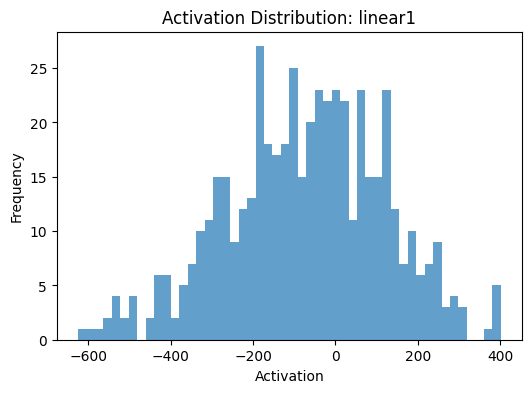

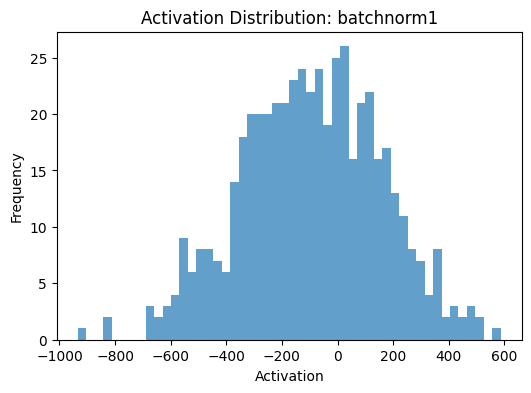

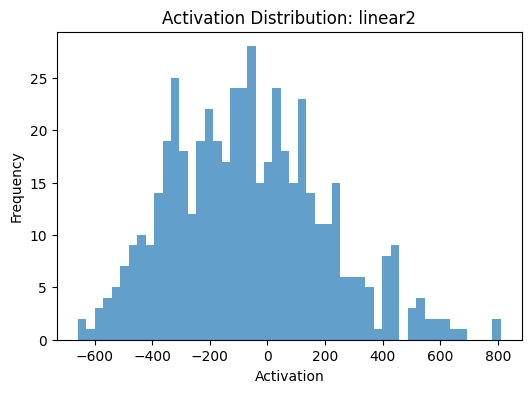

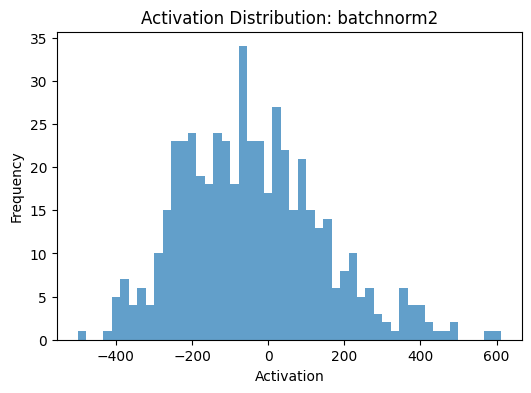

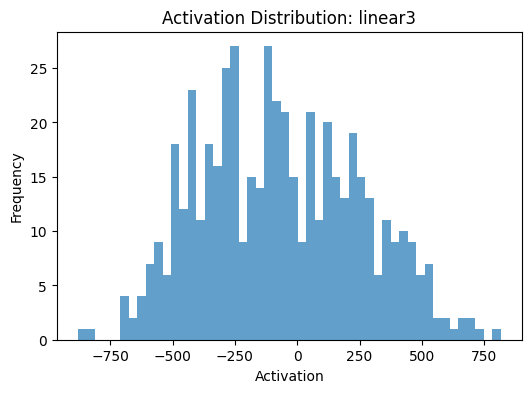

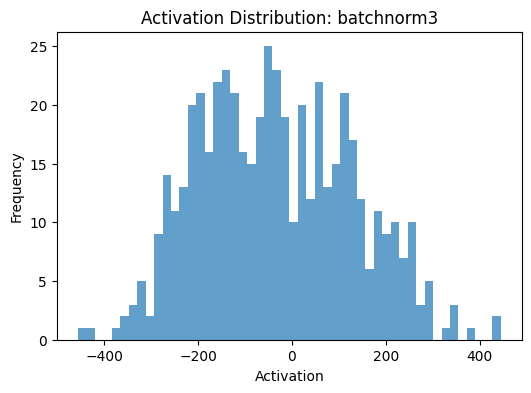

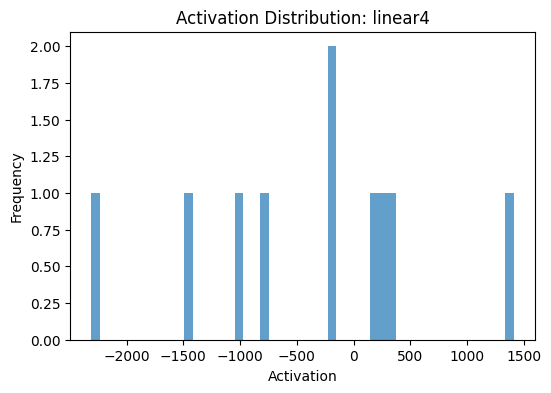

In [13]:
# 활성화를 저장할 딕셔너리
activations = {}

# 훅 함수 정의
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# 관심 있는 레이어에 훅 등록
hook_handles = []
hook_handles.append(model_mlp.linear1.register_forward_hook(get_activation('linear1')))
hook_handles.append(model_mlp.batchnorm1.register_forward_hook(get_activation('batchnorm1')))
hook_handles.append(model_mlp.linear2.register_forward_hook(get_activation('linear2')))
hook_handles.append(model_mlp.batchnorm2.register_forward_hook(get_activation('batchnorm2')))
hook_handles.append(model_mlp.linear3.register_forward_hook(get_activation('linear3')))
hook_handles.append(model_mlp.batchnorm3.register_forward_hook(get_activation('batchnorm3')))
hook_handles.append(model_mlp.linear4.register_forward_hook(get_activation('linear4')))

# 샘플 입력을 모델에 통과
model_mlp.eval()
with torch.no_grad():
    r = random.randint(0, len(mnist_test) - 1)
    # X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to('cpu')
    # Y_single_data = mnist_test.test_labels[r:r + 1].to('cpu')
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to('cuda')
    Y_single_data = mnist_test.test_labels[r:r + 1].to('cuda')
    print('Label: ', Y_single_data.item())
    single_prediction = model_mlp(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

# 활성화 분포 시각화
for layer_name, activation in activations.items():
    plt.figure(figsize=(6,4))
    activation = activation.cpu().numpy().flatten()
    plt.hist(activation, bins=50, alpha=0.7)
    plt.title(f'Activation Distribution: {layer_name}')
    plt.xlabel('Activation')
    plt.ylabel('Frequency')
    plt.show()

In [14]:
# 모든 훅 해제
for handle in hook_handles:
    handle.remove()


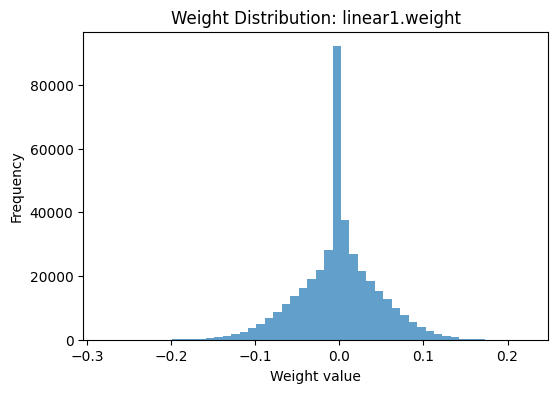

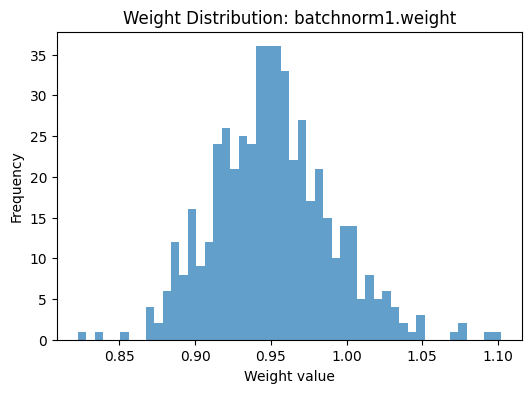

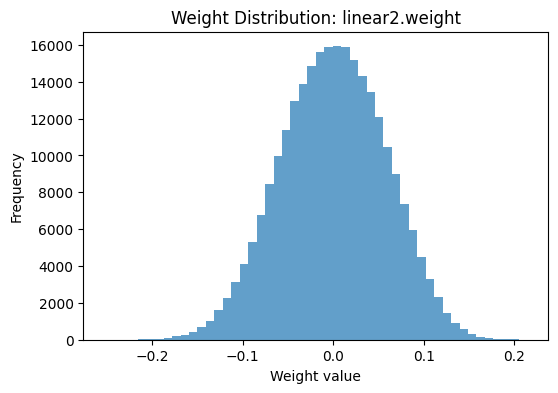

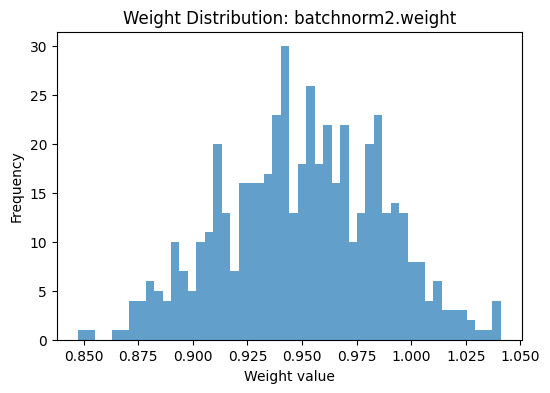

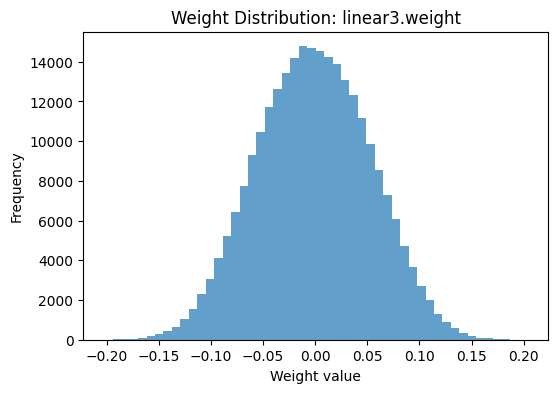

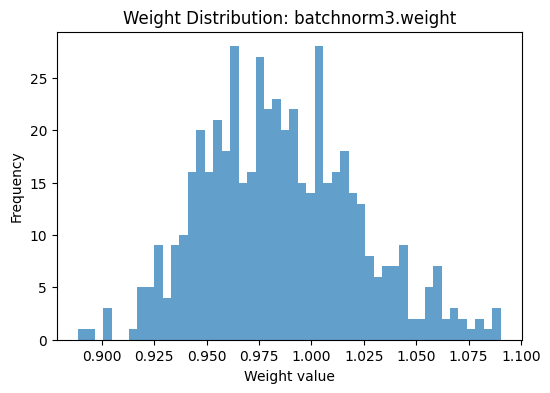

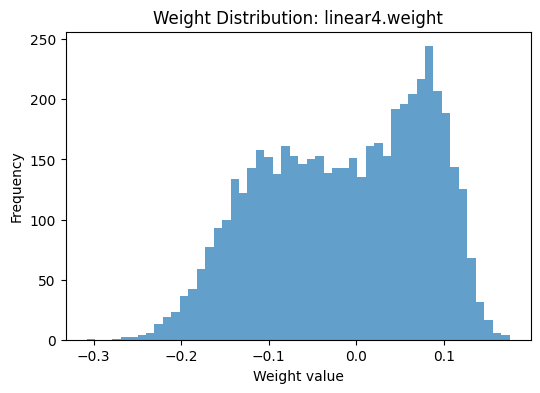

In [15]:
# 가중치 분포 시각화
for name, param in model_mlp.named_parameters():
    if 'weight' in name:
        plt.figure(figsize=(6,4))
        weights = param.cpu().detach().numpy().flatten()
        plt.hist(weights, bins=50, alpha=0.7)
        plt.title(f'Weight Distribution: {name}')
        plt.xlabel('Weight value')
        plt.ylabel('Frequency')
        plt.show()


### Float32 모델 테스트 ###

In [16]:
# Test model and check accuracy
with torch.no_grad():
    model_mlp.eval()    # set the model to evaluation mode (dropout=False)
    device = "cuda"
    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model_mlp(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    #print(len(correct_prediction))
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    
    # 임의의 자료 가져와 일치여부 확인
    r = random.randint(0, len(mnist_test) - 1)
    #print(len(mnist_test))
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model_mlp(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9145999550819397
Label:  5
Prediction:  5


### 파이토치 양자화 ###

In [17]:
model_mlp.to('cpu')
quantized_mlp_torch = torch.quantization.quantize_dynamic(
    model_mlp, {torch.nn.Linear}, dtype=torch.qint8
)
print(quantized_mlp_torch)
#torch.save(quantized_mlp_torch.state_dict(), 'quantized_mlp_torch.pth')
model_mlp = model_mlp.to("cuda")

MLP_model(
  (linear1): DynamicQuantizedLinear(in_features=784, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear2): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear3): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (batchnorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.3, inplace=False)
  (linear4): DynamicQuantizedLinear(in_features=512, out_features=10, d

In [18]:
# quantized_mlp_1 = torch.quantization.quantize_dynamic(
#     model_mlp, {torch.nn.Linear}, dtype=torch.qint8
# )
# quantized_mlp_1

### 사전학습 모델 불러오기 ###

In [19]:
# #model_mlp.load_state_dict(torch.load('model_mlp.pth')) #pytorch model
# quantized_mlp.load_state_dict(torch.load('quantized_mlp.pth')) # pytorch quantization model
# quantized_mlp_1.load_state_dict(torch.load('quantized_mlp_1.pth')) # self quantization model


In [20]:
# print(quantized_mlp_1.linear1.weight())
# #print(quantized_mlp_1.linear1.weight().int_repr())
# # print(quantized_mlp_1.linear1.weight().shape)
# # print(quantized_mlp_1.linear1.weight().dtype)
# print(quantized_mlp_1.linear1.weight().q_scale())
# # print(quantized_mlp_1.linear1.weight().q_zero_point())

# qmin = -128
# qmax = 127

# weight1 = model_mlp.linear1.weight.cpu()
# print(weight1)

# min_val = weight1.min().item()
# max_val = weight1.max().item()
# print(f"Max_val: {max_val}")
# print(f"Min_val: {min_val}")

# # scale1 = (max_val - min_val) / (qmax - qmin)
# scale = max(abs(min_val), abs(max_val)) / qmax
# print(f"Scale: {scale}")

# # zero_point1 = round((0 - min_val) / scale1)
# # zero_point1 = max(qmin, min(qmax, zero_point1))
# zero_point = 0
# print(f"Zero Point: {zero_point}")



In [21]:
# round(weight1[0][0].item() / scale) * scale
# qlinear1 = weight1 / scale
# qlinear1 = qlinear1.cpu()
# qlinear1 = torch.round(qlinear1)
# qlinear1 = torch.clamp(qlinear1, -128, 127)
# qlinear1 = qlinear1.to(torch.int8)
# print(qlinear1)

# # print(torch.equal(qlinear1, quantized_mlp.linear1.weight().int_repr()))
# # comparison = qlinear1 == quantized_mlp.linear1.weight().int_repr()
# # print(comparison)
# # num_differences = torch.numel(comparison) - torch.sum(comparison).item()
# # print(f"Number of differences: {num_differences}")
# # print(num_differences / torch.numel(comparison) * 100)
# #print(weight[0][782].item()/scale)

In [22]:
# qmin = -128
# qmax = 127

# model_linear = {
#     'linear1': model_mlp.linear1.weight.cpu(),
#     'linear2': model_mlp.linear2.weight.cpu(),
#     'linear3': model_mlp.linear3.weight.cpu(),
#     'linear4': model_mlp.linear4.weight.cpu()
# }

# for key, weight in model_linear.items():
#     print(weight)
#     min_val = weight.min().item()
#     max_val = weight.max().item()

#     scale = max(abs(min_val), abs(max_val)) / qmax
#     print(f"Scale: {scale}")
#     zero_point = 0

#     weight_q = torch.quantize_per_tensor(weight, scale, zero_point, torch.qint8)
#     quantized_layer = getattr(quantized_mlp_1, key)
#     quantized_layer.weight = weight_q
#     #quantized_mlp.linear{key}.weight = torch.quantize_per_tensor(weight, scale, zero_point, torch.qint8)

### 양자화 커널 호출 함수 ###

In [23]:
def quantize_symmetric_cuda(weight, num_bits=8):
    quantized_weight, scale = quantize_extension.quantize_symmetric_cuda(weight, num_bits)
    return quantized_weight, scale

# 대칭 양자화를 수행하는 함수
def quantize_symmetric(weight, num_bits=8):
    qmin = -2**(num_bits - 1)
    qmax = 2**(num_bits - 1) - 1
    
    max_val = weight.abs().max()
    scale = max_val / qmax if max_val != 0 else 1.0
    
    quantized_weight = torch.clamp((weight / scale).round(), qmin, qmax).to(torch.int8)
    
    return quantized_weight, scale

# 가중치를 디양자화하는 함수
def dequantize_symmetric(quantized_weight, scale):
    return quantized_weight.float() * scale

# 모델에 수동 동적 양자화를 적용하는 함수
def manual_dynamic_quantization(model):
    quantized_weights = {}
    scales = {}
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            q_weight, scale = quantize_symmetric(module.weight.data)
            quantized_weights[name + '.weight_quantized'] = q_weight
            scales[name + '.weight_scale'] = scale
            # 가중치는 그대로 유지하고, 학습 불가능하게 설정
            module.weight.requires_grad = False
    return quantized_weights, scales

# Quantized Linear 레이어 정의
# class QuantizedLinear(nn.Module):
#     def __init__(self, float_linear, scale, zero_point):
#         super(QuantizedLinear, self).__init__()
#         self.scale = scale
#         self.zero_point = zero_point
#         #self.quantized_weight = float_linear.weight.quantize_per_tensor(scale, zero_point, dtype=torch.qint8)
#         self.quantized_weight = torch.quantize_per_tensor(float_linear.weight, scale, zero_point, dtype=torch.qint8)
#         self.bias = float_linear.bias
#         self.quantized_op = torch.nn.quantized.Linear(
#             float_linear.in_features,
#             float_linear.out_features,
#             float_linear.bias is not None
#         )
#         self.quantized_op.set_weight_bias(self.quantized_weight, self.bias)
    
#     def forward(self, x):
#         return self.quantized_op(x)

# 모델을 수동으로 양자화하는 함수
# def manual_dynamic_quantization(model):
#     quantized_model = copy.deepcopy(model)
#     for name, module in quantized_model.named_modules():
#         if isinstance(module, nn.Linear):
#             # 가중치의 최대 절대값을 구해 스케일 계산
#             max_val = module.weight.abs().max()
#             scale = max_val / 127  # int8의 범위는 -128 ~ 127
            
#             # 제로 포인트는 0 (대칭 양자화)
#             zero_point = 0
            
#             # QuantizedLinear로 교체
#             parent = quantized_model
#             names = name.split('.')
#             for n in names[:-1]:
#                 parent = getattr(parent, n)
#             setattr(parent, names[-1], QuantizedLinear(module, scale, zero_point))
#     return quantized_model

In [24]:
# import torch.nn as nn

# class QuantizedLinear(nn.Module):
#     def __init__(self, linear_module):
#         """
#         QuantizedLinear 레이어 초기화.
        
#         Args:
#             linear_module (nn.Linear): 원본 nn.Linear 레이어.
#         """
#         super(QuantizedLinear, self).__init__()
#         self.in_features = linear_module.in_features
#         self.out_features = linear_module.out_features
#         self.bias = linear_module.bias

#         # 가중치 양자화
#         # self.weight_int8, self.weight_scale = quantize_symmetric(linear_module.weight.data)
#         self.weight_int8, self.weight_scale = quantize_symmetric_cuda(linear_module.weight.data)


#     def forward(self, x):
#         """
#         순전파 시 양자화된 입력과 가중치를 사용하여 연산을 수행하고, 결과를 디양자화합니다.
        
#         Args:
#             x (torch.Tensor): 부동 소수점 입력 텐서.
        
#         Returns:
#             torch.Tensor: 디양자화된 출력 텐서.
#         """
#         # 입력 양자화
#         x_int8, x_scale = quantize_symmetric(x)
#         x_int8, x_scale = quantize_symmetric_cuda(x)

#         # int8 행렬 곱셈 (결과는 int32)
#         # PyTorch는 int8 x int8 -> int32 지원
#         # 하지만, torch.matmul은 int8을 지원하지 않으므로, 이를 시뮬레이션
#         # 따라서, int8을 int32로 캐스팅 후 연산
#         x_int32 = x_int8.int()
#         weight_int32 = self.weight_int8.int()

#         # 행렬 곱 (int32 결과)
#         output_int32 = torch.matmul(x_int32, weight_int32.t())

#         # 스케일 결합
#         output_scale = x_scale * self.weight_scale

#         # 디양자화
#         output = output_int32.float() * output_scale

#         # 바이어스 추가 (부동 소수점)
#         if self.bias is not None:
#             output += self.bias

#         return output
    

# def replace_with_quantized_linear(model):
#     quantized_model = copy.deepcopy(model)
#     for name, module in quantized_model.named_modules():
#         if isinstance(module, nn.Linear):
            
            

#             # QuantizedLinear로 교체
#             parent = quantized_model
#             names = name.split('.')
#             for n in names[:-1]:
#                 parent = getattr(parent, n)
#             setattr(parent, names[-1], QuantizedLinear(module))
#     return quantized_model


In [25]:
import torch.nn as nn

class CustomQuantizedLinear_cpu(nn.Module):
    def __init__(self, linear_module, layer_name):
        """
        CustomQuantizedLinear 레이어 초기화.

        Args:
            linear_module (nn.Linear): 원본 nn.Linear 레이어.
            layer_name (str): 레이어의 고유 이름.
        """
        super(CustomQuantizedLinear_cpu, self).__init__()
        self.layer_name = layer_name
        self.in_features = linear_module.in_features
        self.out_features = linear_module.out_features
        self.bias = linear_module.bias

        # 가중치 양자화
        # self.weight_int8, self.weight_scale = quantize_symmetric(linear_module.weight.data)
        weight = linear_module.weight
        #weight = linear_module.weight.to('cuda')
        self.weight_int8, self.weight_scale = quantize_extension.quantize_symmetric_cuda(weight, 8)
        self.weight_int8 = self.weight_int8.to('cuda')
        self.weight_scale = self.weight_scale.to('cuda')
        #self.weight_int8 = self.weight_int8.to('cpu')
        #self.weight_scale = self.weight_scale.to('cpu')
        self.bias = self.bias.to('cuda')
        
        # 버퍼로 등록하여 state_dict에 포함 (고유한 이름 사용)
        self.register_buffer(f'{layer_name}_weight_int8', self.weight_int8)
        self.register_buffer(f'{layer_name}_weight_scale', self.weight_scale)
        self.register_buffer(f'{layer_name}_bias', self.bias)
        #self.register_buffer(f'{layer_name}_weight_scale', torch.tensor(self.weight_scale))
        #self.register_buffer(f'{layer_name}_weight_scale', torch.tensor(self.weight_scale, device='cuda'))
        
    def forward(self, x):
        """
        순전파 시 양자화된 입력과 가중치를 사용하여 연산을 수행하고, 결과를 디양자화합니다.

        Args:
            x (torch.Tensor): 부동 소수점 입력 텐서.

        Returns:
            torch.Tensor: 디양자화된 출력 텐서.
        """
        # 입력 양자화
        # x_int8, x_scale = quantize_symmetric(x)
        x = x.to('cuda')
        if not x.is_cuda:
            raise ValueError("Input tensor must be on CUDA device")
    
        x_int8, x_scale = quantize_extension.quantize_symmetric_cuda(x, 8)
        # x_int8 = x_int8.to('cuda')
        # if not x_int8.is_cuda:
        #     raise ValueError("Input quantized tensor must be on CUDA device")
        # x_scale = x_scale.to('cuda')
        # if not x_scale.is_cuda: 
        #     raise ValueError("Input scale tensor must be on CUDA device")
        #x_int8 = x_int8.to('cpu')

        # int8 행렬 곱셈을 시뮬레이션 (torch.matmul은 int8을 직접 지원하지 않음)
        x_int32 = x_int8.int().cpu()
        weight_int32 = getattr(self, f'{self.layer_name}_weight_int8').int().cpu()
        weight_int8 = getattr(self, f'{self.layer_name}_weight_int8')
        weight_int8_t = weight_int8.t()
        # if not weight_int8_t.is_cuda:
        #     raise ValueError("Quantized weight tensor must be on CUDA device")

        # M, K = x_int8.size()
        # N = weight_int8.size(0)
        # pad_multiple = 4

        # # 각 차원에 대한 패딩 계산
        # def calculate_padding(size, multiple):
        #     return (multiple - (size % multiple)) % multiple
        
        # padding_M = calculate_padding(M, pad_multiple)
        # padding_K = calculate_padding(K, pad_multiple)
        # padding_N = calculate_padding(N, pad_multiple)

        # # 패딩된 크기
        # M_padded = M + padding_M
        # K_padded = K + padding_K
        # N_padded = N + padding_N

        # # 패딩이 필요한 경우, 0으로 패딩
        # if padding_M > 0:
        #     pad_a_M = torch.zeros((padding_M, K), dtype=torch.int8, device='cuda')
        #     x_padded = torch.cat([x_int8, pad_a_M], dim=0)
        # else:
        #     x_padded = x_int8
        
        # if padding_K > 0:
        #     pad_a_K = torch.zeros((M_padded, padding_K), dtype=torch.int8, device='cuda')
        #     x_padded = torch.cat([x_padded, pad_a_K], dim=1)

        #     pad_b_K = torch.zeros((padding_K, N), dtype=torch.int8, device='cuda')
        #     weight_int8_padded = torch.cat([weight_int8_t, pad_b_K], dim=0)
        # else:
        #     weight_int8_padded = weight_int8_t
        
        # if padding_N > 0:
        #     pad_b_N = torch.zeros((K_padded, padding_N), dtype=torch.int8, device='cuda')
        #     weight_int8_padded = torch.cat([weight_int8_padded, pad_b_N], dim=1)
        


        # 행렬 곱 (int32 결과)
        output_int32 = torch.matmul(x_int32, weight_int32.t())
        #output_int8 = quantize_extension.matmul_int8_cuda(x_padded, weight_int8_padded)
        #output_int8 = output_int8[:M, :N]

        # output_int8 = output_int8.to('cuda')
        # if not output_int8.is_cuda:
        #     raise ValueError("Output quantized tensor must be on CUDA device")
        

        # 스케일 결합
        weight_scale = getattr(self, f'{self.layer_name}_weight_scale')
        output_scale = x_scale.item() * weight_scale.item()
        #output_scale = x_scale * self.weight_scale
        
        # 디양자화
        output = output_int32.float() * output_scale
        #output = output_int8.float() * output_scale
        # output = output.to('cuda')
        # if not output.is_cuda:
        #     raise ValueError("Output tensor must be on CUDA device")
        
        bias = getattr(self, f'{self.layer_name}_bias')
        # 바이어스 추가 (부동 소수점)
        if bias is not None:
            output += bias

        # output = output.to('cuda')
        # if not output.is_cuda:
        #     raise ValueError("Output tensor must be on CUDA device")
        
        return output

    def __repr__(self):
        return f"CustomQuantizedLinear_cpu(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None})"
    
# def replace_with_custom_quantized_linear(model):
#     quantized_model = copy.deepcopy(model)
#     #quantized_model = model
#     for name, module in quantized_model.named_modules():
#         if isinstance(module, nn.Linear):
#             # 고유한 레이어 이름 생성 (버퍼 이름 충돌 방지)
#             layer_name = name.replace('.', '_')  # 예: 'layer1.linear1' -> 'layer1_linear1'
#             quantized_linear = CustomQuantizedLinear(module, layer_name)
#             # 부모 모듈 찾기
#             parent = quantized_model
#             names = name.split('.')
#             for n in names[:-1]:
#                 parent = getattr(parent, n)
#             # 레이어 교체
#             setattr(parent, names[-1], quantized_linear)
#     return quantized_model

def replace_with_custom_quantized_linear_cpu(model):
    # 모델을 새로운 인스턴스로 초기화
    quantized_model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # 부모 모듈 찾기
            parent = quantized_model
            names = name.split('.')
            for n in names[:-1]:
                parent = getattr(parent, n)
            linear_name = names[-1]
            # 커스텀 양자화 선형 계층으로 교체
            custom_linear = CustomQuantizedLinear_cpu(module, linear_name)
            setattr(parent, linear_name, custom_linear)
    return quantized_model


### 커스텀 layer ###

In [26]:
import torch.nn as nn

class CustomQuantizedLinear(nn.Module):
    def __init__(self, linear_module, layer_name):
        """
        CustomQuantizedLinear 레이어 초기화.

        Args:
            linear_module (nn.Linear): 원본 nn.Linear 레이어.
            layer_name (str): 레이어의 고유 이름.
        """
        super(CustomQuantizedLinear, self).__init__()
        self.layer_name = layer_name
        self.in_features = linear_module.in_features
        self.out_features = linear_module.out_features
        self.bias = linear_module.bias

        # 가중치 양자화
        # self.weight_int8, self.weight_scale = quantize_symmetric(linear_module.weight.data)
        weight = linear_module.weight
        #weight = linear_module.weight.to('cuda')
        self.weight_int8, self.weight_scale = quantize_extension.quantize_symmetric_cuda(weight, 8)
        self.weight_int8 = self.weight_int8.to('cuda')
        self.weight_scale = self.weight_scale.to('cuda')
        #self.weight_int8 = self.weight_int8.to('cpu')
        #self.weight_scale = self.weight_scale.to('cpu')
        self.bias = self.bias.to('cuda')
        
        # 버퍼로 등록하여 state_dict에 포함 (고유한 이름 사용)
        self.register_buffer(f'{layer_name}_weight_int8', self.weight_int8)
        self.register_buffer(f'{layer_name}_weight_scale', self.weight_scale)
        self.register_buffer(f'{layer_name}_bias', self.bias)
        #self.register_buffer(f'{layer_name}_weight_scale', torch.tensor(self.weight_scale))
        #self.register_buffer(f'{layer_name}_weight_scale', torch.tensor(self.weight_scale, device='cuda'))
        
    def forward(self, x):
        """
        순전파 시 양자화된 입력과 가중치를 사용하여 연산을 수행하고, 결과를 디양자화합니다.

        Args:
            x (torch.Tensor): 부동 소수점 입력 텐서.

        Returns:
            torch.Tensor: 디양자화된 출력 텐서.
        """
        # 입력 양자화
        # x_int8, x_scale = quantize_symmetric(x)
        x = x.to('cuda')
        if not x.is_cuda:
            raise ValueError("Input tensor must be on CUDA device")
    
        x_int8, x_scale = quantize_extension.quantize_symmetric_cuda(x, 8)
        # x_int8 = x_int8.to('cuda')
        # if not x_int8.is_cuda:
        #     raise ValueError("Input quantized tensor must be on CUDA device")
        # x_scale = x_scale.to('cuda')
        # if not x_scale.is_cuda: 
        #     raise ValueError("Input scale tensor must be on CUDA device")
        #x_int8 = x_int8.to('cpu')

        # int8 행렬 곱셈을 시뮬레이션 (torch.matmul은 int8을 직접 지원하지 않음)
        #x_int32 = x_int8.int().cpu()
        #weight_int32 = getattr(self, f'{self.layer_name}_weight_int8').int().cpu()
        weight_int8 = getattr(self, f'{self.layer_name}_weight_int8')
        weight_int8_t = weight_int8.t()
        # if not weight_int8_t.is_cuda:
        #     raise ValueError("Quantized weight tensor must be on CUDA device")

        a = x_int8
        #b = weight_int8_t.contiguous()
        b = weight_int8

        M = a.size(0)
        K = a.size(1)
        N = b.size(0)
        pad_multiple = 8

        # 각 차원에 대한 패딩 계산
        def calculate_padding(size, multiple):
            return (multiple - (size % multiple)) % multiple
        
        padding_M = calculate_padding(M, pad_multiple)
        padding_K = calculate_padding(K, pad_multiple)
        padding_N = calculate_padding(N, pad_multiple)

        # 패딩된 크기
        M_padded = M + padding_M
        K_padded = K + padding_K
        N_padded = N + padding_N

        # # 패딩이 필요한 경우, 0으로 패딩
        # if padding_M > 0:
        #     pad_a_M = torch.zeros((padding_M, K), dtype=torch.int8, device='cuda')
        #     a_padded = torch.cat([a, pad_a_M], dim=0)
        # else:
        #     a_padded = a

        # if padding_K > 0:
        #     pad_a_K = torch.zeros((M_padded, padding_K), dtype=torch.int8, device='cuda')
        #     a_padded = torch.cat([a_padded, pad_a_K], dim=1)
            
        #     pad_b_K = torch.zeros((padding_K, N), dtype=torch.int8, device='cuda')
        #     b_padded = torch.cat([b, pad_b_K], dim=0)
        # else:
        #     b_padded = b

        # if padding_N > 0:
        #     pad_b_N = torch.zeros((K_padded, padding_N), dtype=torch.int8, device='cuda')
        #     b_padded = torch.cat([b_padded, pad_b_N], dim=1)

        # 패딩이 필요한 경우, 0으로 패딩
        if padding_M > 0:
            pad_a_M = torch.zeros((padding_M, K), dtype=torch.int8, device='cuda')
            a_padded = torch.cat([a, pad_a_M], dim=0)
        else:
            a_padded = a

        if padding_K > 0:
            pad_a_K = torch.zeros((M_padded, padding_K), dtype=torch.int8, device='cuda')
            a_padded = torch.cat([a_padded, pad_a_K], dim=1)
            
            pad_b_K = torch.zeros((N, padding_K), dtype=torch.int8, device='cuda')
            b_padded = torch.cat([b, pad_b_K], dim=1)
        else:
            b_padded = b

        if padding_N > 0:
            pad_b_N = torch.zeros((padding_N, K_padded), dtype=torch.int8, device='cuda')
            b_padded = torch.cat([b_padded, pad_b_N], dim=0)

        b_padded = b_padded.t()
        # 행렬 곱 (int32 결과)
        #output_int32 = torch.matmul(x_int32, weight_int32.t())
        output_int8 = quantize_extension.matmul_int8_cuda(a_padded, b_padded)
        output_int8 = output_int8[:M, :N]
        
        
        # output_int8 = output_int8.to('cuda')
        # if not output_int8.is_cuda:
        #     raise ValueError("Output quantized tensor must be on CUDA device")
        

        # 스케일 결합
        weight_scale = getattr(self, f'{self.layer_name}_weight_scale')
        output_scale = x_scale.item() * weight_scale.item()
        #output_scale = x_scale * self.weight_scale
        
        # 디양자화
        #output = output_int32.float() * output_scale
        output = output_int8.float() * output_scale
        # output = output.to('cuda')
        # if not output.is_cuda:
        #     raise ValueError("Output tensor must be on CUDA device")
        
        bias = getattr(self, f'{self.layer_name}_bias')
        # 바이어스 추가 (부동 소수점)
        if bias is not None:
            output += bias

        # output = output.to('cuda')
        # if not output.is_cuda:
        #     raise ValueError("Output tensor must be on CUDA device")
        
        return output

    def __repr__(self):
        return f"CustomQuantizedLinear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None})"
    
# def replace_with_custom_quantized_linear(model):
#     quantized_model = copy.deepcopy(model)
#     #quantized_model = model
#     for name, module in quantized_model.named_modules():
#         if isinstance(module, nn.Linear):
#             # 고유한 레이어 이름 생성 (버퍼 이름 충돌 방지)
#             layer_name = name.replace('.', '_')  # 예: 'layer1.linear1' -> 'layer1_linear1'
#             quantized_linear = CustomQuantizedLinear(module, layer_name)
#             # 부모 모듈 찾기
#             parent = quantized_model
#             names = name.split('.')
#             for n in names[:-1]:
#                 parent = getattr(parent, n)
#             # 레이어 교체
#             setattr(parent, names[-1], quantized_linear)
#     return quantized_model

def replace_with_custom_quantized_linear(model):
    # 모델을 새로운 인스턴스로 초기화
    quantized_model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # 부모 모듈 찾기
            parent = quantized_model
            names = name.split('.')
            for n in names[:-1]:
                parent = getattr(parent, n)
            linear_name = names[-1]
            # 커스텀 양자화 선형 계층으로 교체
            custom_linear = CustomQuantizedLinear(module, linear_name)
            setattr(parent, linear_name, custom_linear)
    return quantized_model


In [27]:

# GPU 텐서 생성
weight = torch.randn(10000, 10000, device='cuda')
print(weight.abs().max())

# 양자화 수행
quantized_weight, scale = quantize_symmetric_cuda(weight)
print(type(scale))
#quantized_weight, scale = quantize_symmetric(weight)
quantized_weight = quantized_weight.to('cpu')
#scale = scale.to('cpu')
#scale = torch.tensor([[scale]])
print(type(scale))
print(f"Quantized Weight dtype: {quantized_weight.dtype}")  # torch.int8
print(f"Scale dtype: {scale.dtype}")  # 스케일 값
print(f"Scale: {scale}")  # 스케일 값
print(quantized_weight)
print(quantized_weight.device)
#print(scale.type())
print(weight[9999][9999].item() / scale.item())

tensor(5.4503, device='cuda:0')
<class 'torch.Tensor'>


<class 'torch.Tensor'>
Quantized Weight dtype: torch.int8
Scale dtype: torch.float32
Scale: tensor([[0.0429]])
tensor([[ 28, -15,  15,  ..., -26, -57,  21],
        [ 11,  39,   6,  ...,  10,  19,  -1],
        [ 12, -26,  -1,  ...,  -5,  27, -11],
        ...,
        [-33, -70,  15,  ..., -33,  17,  31],
        [ -3,  22, -49,  ..., -34,  10,   7],
        [ 19,  33, -43,  ...,  45,  13, -12]], dtype=torch.int8)
cpu
-12.102825533779548


In [28]:
for param in model_mlp.parameters():
    assert param.is_cuda, "모든 파라미터가 GPU에 있어야 합니다."


### 커스텀 layer 교체 ###

In [29]:
#original_model = model_mlp

original_model = model_mlp

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


#quantized_weights, scales = manual_dynamic_quantization(original_model)
#quantized_model_mlp = QuantizedMLP_model(original_model, quantized_weights, scales)
#quantized_model_mlp = manual_dynamic_quantization(original_model)

#quantized_model_mlp = replace_with_quantized_linear(original_model)

quantized_model_mlp_cpu = replace_with_custom_quantized_linear_cpu(original_model)
quantized_model_mlp = replace_with_custom_quantized_linear(original_model)
    


print(quantized_model_mlp.eval())
print(quantized_model_mlp.linear1.weight_int8.dtype)

# 모델 크기 비교 함수
def get_size(model):
    import io
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    size_mb = buffer.tell() / 1e6
    return size_mb

print(f"Original model size: {get_size(original_model):.3f} MB")
#print(f"Quantized mlp model size: {get_size(quantized_mlp):.2f} MB")
print(f"pytorch Quantized model size: {get_size(quantized_mlp_torch):.3f} MB")
print(f"custom Quantized model size: {get_size(quantized_model_mlp):.3f} MB")

MLP_model(
  (linear1): CustomQuantizedLinear(in_features=784, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear2): CustomQuantizedLinear(in_features=512, out_features=512, bias=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear3): CustomQuantizedLinear(in_features=512, out_features=512, bias=True)
  (batchnorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.3, inplace=False)
  (linear4): CustomQuantizedLinear(in_features=512, out_features=10, bias=True)
)
torch.int8
Original model size: 3.761 MB
pytorch Quantized model size: 0.971 MB
custom Quantized model size: 0.971 

In [30]:
for param in quantized_model_mlp.parameters():
    assert param.is_cuda, "모든 파라미터가 GPU에 있어야 합니다."


In [31]:
print(quantized_model_mlp.linear1.weight_int8[0])
print(quantized_model_mlp.linear1.weight_scale)

# print(quantized_model_mlp.linear2.weight_int8)
# print(quantized_model_mlp.linear2.weight_scale)

# print(quantized_model_mlp.linear3.weight_int8)
# print(quantized_model_mlp.linear3.weight_scale)

# print(quantized_model_mlp.linear4.weight_int8)
# print(quantized_model_mlp.linear4.weight_scale)



tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   2,
         -4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  -1,  -3,  -6,  -9, -10,  -5, -12, -16, -17,
        -24,  19,  19,  14,  15,  11,  -4,  -8,  -7,  -1,   0,   0,   0,   0,
          0,   0,  -5,  -1,  -2,  -1,  -6, -12, -24,  -2,  11, -13,  -4, -23,
          6,   7,  -5,  22, -10,   5, -15, -13,  13,  14,  12,   4,   0,   0,
          0,   0,  -3,  -4,  -6,   9,   1, -23,  -7,   2, -40, -16,   9,  10,
         13,  15, -10, -28, -40, -25, -17, -21, -25,   7,  11,   3,   4,   0,
          0,   0,   2,  -1,  10,  -6,  14, -31, -24, -13,   2,  10,  31,  14,
         10,  -5,   1, -33, -28, -33, -27,  -1, -39,  16,  -3,   6, -11,   1,
          0,   0,   2, -11, -17, -13,  -7, -34,  14,   9,  26,  23,  17,   0,
        -30,  -3,   6, -18, -29,  29,   7,  -8, -13,   5,  13,  -7,  15,   2,
          0,   0,  -5,  -2, -25,  21,  30,  -4, -15,  -8, -41, -

In [32]:
# # torch.save(quantized_model_mlp.state_dict(), 'quantized_model_mlp.pth')

# # 양자화된 모델 로드
# def load_quantized_model(filepath):
#     original_model = model_mlp
#     quantized_model_mlp = replace_with_custom_quantized_linear(original_model)
#     quantized_model_mlp.load_state_dict(torch.load(filepath))
#     quantized_model_mlp.eval()
#     return quantized_model_mlp

# #quantized_model_mlp = load_quantized_model('quantized_model_mlp.pth')

In [33]:
# for name, module in quantized_mlp_1.named_modules():
#     if isinstance(module, torch.nn.quantized.Linear):
#         print(f"레이어: {name}")
#         #print(f"  Weight Scale: {module.weight.q_scale()}")
#         #print(f"  Weight Zero Point: {module.weight.q_zero_point()}")
#         print(f"  Weight: {module.weight}")
# #torch.save(quantized_mlp_1.state_dict(), 'quantized_mlp_1.pth')

In [34]:
# print(quantized_mlp_1.linear1.weight)
# print(quantized_mlp_1.linear1.weight.int_repr())
# print(quantized_mlp_1.linear1.weight.shape)
# print(quantized_mlp_1.linear1.weight.dtype)
# print(quantized_mlp_1.linear1.weight.q_scale())
# print(quantized_mlp_1.linear1.weight.q_zero_point())

In [35]:
# print(quantized_mlp.linear1.weight())
# print(quantized_mlp.linear1.weight().int_repr())
# print(quantized_mlp.linear1.weight().shape)
# print(quantized_mlp.linear1.weight().dtype)
# print(quantized_mlp.linear1.weight().q_scale())
# print(quantized_mlp.linear1.weight().q_zero_point())

In [36]:
# Test model and check accuracy
with torch.no_grad():
    quantized_mlp_torch.eval()    # set the model to evaluation mode (dropout=False)
    quantized_mlp_torch.cpu()
    
    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to('cpu')
    Y_test = mnist_test.test_labels.to('cpu')
    
    
    prediction = quantized_mlp_torch(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    #print(len(correct_prediction))
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    
    # 임의의 자료 가져와 일치여부 확인
    r = random.randint(0, len(mnist_test) - 1)
    #print(len(mnist_test))
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float()
    Y_single_data = mnist_test.test_labels[r:r + 1]
    

    print('Label: ', Y_single_data.item())

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    elapsed_time_ms = 0
    num_runs = 1
    for i in range(num_runs):

        start_event.record()
        #start_time = time.time()
        single_prediction = quantized_mlp_torch(X_single_data)
        #end_time = time.time()
        #elapsed_time_ms = (end_time - start_time) * 1000  # 초를 밀리초로 변환
        #print("quantization using torch: {:.3f} ms".format(elapsed_time_ms))
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)
    print("quantization using torch: {:.3f} ms".format(elapsed_time_ms/num_runs))

    #print(quantized_mlp.linear1.weight())
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9115999937057495
Label:  7
quantization using torch: 1.356 ms
Prediction:  7


In [37]:
# # Test model and check accuracy
# with torch.no_grad():
#     quantized_mlp_1.eval()    # set the model to evaluation mode (dropout=False)
#     quantized_mlp_1.cpu()
#     #print(device)
#     # Test the model using test sets
#     X_test = mnist_test.test_data.view(-1, 28 * 28).float()
#     Y_test = mnist_test.test_labels
#     print(X_test.device)
    
#     prediction = quantized_mlp_1(X_test)
#     correct_prediction = torch.argmax(prediction, 1) == Y_test
#     #print(len(correct_prediction))
#     accuracy = correct_prediction.float().mean()
#     print('Accuracy:', accuracy.item())
    
#     # 임의의 자료 가져와 일치여부 확인
#     r = random.randint(0, len(mnist_test) - 1)
#     #print(len(mnist_test))
#     X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float()
#     Y_single_data = mnist_test.test_labels[r:r + 1]

#     print('Label: ', Y_single_data.item())
#     single_prediction = quantized_mlp_1(X_single_data)
#     print(quantized_mlp_1.linear1.weight)
#     print('Prediction: ', torch.argmax(single_prediction, 1).item())

In [38]:
# torch.cuda.empty_cache()

# for param in quantized_model_mlp.parameters():
#     param.data = param.data.cpu()
#     if param.grad is not None:
#         param.grad.data = param.grad.data.cpu()

# for buffer in quantized_model_mlp.buffers():
#     buffer.data = buffer.data.cpu()


In [39]:
# Test model and check accuracy
with torch.no_grad():
    quantized_model_mlp_cpu.eval()    # set the model to evaluation mode (dropout=False)
    quantized_model_mlp_cpu.cpu()
    
    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to('cpu').contiguous()
    Y_test = mnist_test.test_labels.to('cpu')
    # X_test = mnist_test.test_data.view(-1, 28 * 28).float().to('cuda').contiguous()
    # Y_test = mnist_test.test_labels.to('cuda')
    
    prediction = quantized_model_mlp_cpu(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    #print(len(correct_prediction))
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    
    # 임의의 자료 가져와 일치여부 확인
    r = random.randint(0, len(mnist_test) - 1)
    #print(len(mnist_test))
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to('cpu')
    Y_single_data = mnist_test.test_labels[r:r + 1].to('cpu')
    # X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to('cuda').contiguous()
    # Y_single_data = mnist_test.test_labels[r:r + 1].to('cuda')

    print('Label: ', Y_single_data.item())
    single_prediction = quantized_model_mlp_cpu(X_single_data)
    # print(quantized_model_mlp.linear1.weight_int8[0])
    # print(quantized_model_mlp.linear1.weight_scale)
    # print(quantized_model_mlp.linear2.weight_int8)
    # print(quantized_model_mlp.linear3.weight_int8)
    # print(quantized_model_mlp.linear4.weight_int8)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9111999869346619
Label:  9
Prediction:  9


In [40]:
# print(model_mlp.linear4.weight.shape)
# print(quantized_model_mlp.linear4.weight_int8.shape)
# print(quantized_model_mlp.linear4.weight_int8)

In [41]:
a = quantized_model_mlp.linear1.weight_int8[0]
b = quantized_model_mlp_cpu.linear1.weight_int8[0]

m = a - b
print(m.nonzero())

tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)


In [42]:
#print(quantized_model_mlp.linear1.weight_int8.shape)
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to('cuda').contiguous()
Y_single_data = mnist_test.test_labels[r:r + 1].to('cuda')

#x_int8, x_scale = quantize_extension.quantize_symmetric_cuda(X_single_data, 8)

#res = quantize_extension.matmul_int8_cuda(x_int8, quantized_model_mlp.linear1.weight_int8.t())
#res_cpu = quantize_extension.matmul_int8_cuda(x_int8, quantized_model_mlp_cpu.linear1.weight_int8.t())
#output_scale = x_scale.item() * quantized_model_mlp.linear1.weight_scale.item()
#res = res.float().to('cuda') * output_scale 
#res = res + quantized_model_mlp.linear1.bias

quantized_model_mlp = quantized_model_mlp.to('cuda')
res = quantized_model_mlp.linear1(X_single_data)

quantized_model_mlp_cpu = quantized_model_mlp_cpu.to('cpu')
res_cpu = quantized_model_mlp_cpu.linear1(X_single_data)

m = res.cpu() - res_cpu 
#print(m.abs().max())
#print(res)
#print(res_cpu)

# res = quantized_model_mlp.batchnorm1(res)
# res = quantized_model_mlp.relu1(res)
# res = quantized_model_mlp.dropout1(res)
# #print(res.shape)
# res = quantized_model_mlp.linear2(res)
# res = quantized_model_mlp.batchnorm2(res)
# res = quantized_model_mlp.relu2(res)
# res = quantized_model_mlp.dropout2(res)
# #print(res.shape)
# res = quantized_model_mlp.linear3(res)
# res = quantized_model_mlp.batchnorm3(res)
# res = quantized_model_mlp.relu3(res)
# res = quantized_model_mlp.dropout3(res)
# #print(res.shape)
# # x_int, x_scale = quantize_extension.quantize_symmetric_cuda(res, 8)
# # x_int = x_int.to('cuda')
# # weight_int8 = quantized_model_mlp.linear4.weight_int8
# # weight_int8_t = weight_int8.t().to('cuda')
# # res = quantize_extension.matmul_int8_cuda(x_int, weight_int8_t)
# # print(res.shape)

# res = quantized_model_mlp.linear4(res)
# print(res.shape)

# ans = model_mlp(X_single_data)
# print(Y_single_data.item())
# print('Prediction: ', torch.argmax(ans, 1).item())
# print('Quantized Prediction: ', torch.argmax(res, 1).item())

### 모델 크기 ###

In [43]:
print(f"Original model size: {get_size(original_model):.3f} MB")
print(f"pytorch Quantized model size: {get_size(quantized_mlp_torch):.3f} MB")
print(f"custom Quantized model size: {get_size(quantized_model_mlp):.3f} MB")

Original model size: 3.761 MB
pytorch Quantized model size: 0.971 MB
custom Quantized model size: 0.970 MB


### 파이토치 양자화 모델 테스트 ###

In [44]:
# Test model and check accuracy
with torch.no_grad():
    quantized_mlp_torch.eval()    # set the model to evaluation mode (dropout=False)
    quantized_mlp_torch.cpu()
    
    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to('cpu')
    Y_test = mnist_test.test_labels.to('cpu')
    
    
    prediction = quantized_mlp_torch(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    #print(len(correct_prediction))
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    
    # 임의의 자료 가져와 일치여부 확인
    r = random.randint(0, len(mnist_test) - 1)
    #print(len(mnist_test))
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float()
    Y_single_data = mnist_test.test_labels[r:r + 1]
    

    print('Label: ', Y_single_data.item())


    elapsed_time_ms = 0
    num_runs = 1
    for i in range(num_runs):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        #start_time = time.time()
        single_prediction = quantized_mlp_torch(X_single_data)
        #end_time = time.time()
        #elapsed_time_ms = (end_time - start_time) * 1000  # 초를 밀리초로 변환
        #print("quantization using torch: {:.3f} ms".format(elapsed_time_ms))
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)
    print("quantization using torch: {:.3f} ms".format(elapsed_time_ms/num_runs))

    #print(quantized_mlp.linear1.weight())
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9115999937057495
Label:  5
quantization using torch: 1.024 ms
Prediction:  5


### 커스텀 양자화 모델 테스트 ###

In [45]:
# Test model and check accuracy
with torch.no_grad():
    quantized_model_mlp.eval()    # set the model to evaluation mode (dropout=False)
    quantized_model_mlp.to('cuda')

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to('cuda').contiguous()
    Y_test = mnist_test.test_labels.to('cuda')
    
    prediction = quantized_model_mlp(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    #print(len(correct_prediction))
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    
    # 임의의 자료 가져와 일치여부 확인
    r = random.randint(0, len(mnist_test) - 1)
    #print(len(mnist_test))
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to('cuda').contiguous()
    Y_single_data = mnist_test.test_labels[r:r + 1].to('cuda')

    print('Label: ', Y_single_data.item())

    elapsed_time_ms = 0
    num_runs = 1
    for i in range(num_runs):
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        #start_time = time.time()
        single_prediction = quantized_model_mlp(X_single_data)
        #end_time = time.time()
        #elapsed_time_ms = (end_time - start_time) * 1000  # 초를 밀리초로 변환
        #print("quantization using torch: {:.3f} ms".format(elapsed_time_ms))
        end_event.record()
        torch.cuda.synchronize()
        elapsed_time_ms += start_event.elapsed_time(end_event)
    #print("quantization using cuda: {:.3f} ms".format(elapsed_time_ms/num_runs))

    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9111999869346619
Label:  2
Prediction:  2


In [46]:
quantized_model_mlp

MLP_model(
  (linear1): CustomQuantizedLinear(in_features=784, out_features=512, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear2): CustomQuantizedLinear(in_features=512, out_features=512, bias=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear3): CustomQuantizedLinear(in_features=512, out_features=512, bias=True)
  (batchnorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.3, inplace=False)
  (linear4): CustomQuantizedLinear(in_features=512, out_features=10, bias=True)
)

In [47]:
# a = quantized_mlp.linear1.weight()
# b = quantized_mlp_1.linear1.weight
# print(a)
# print(b)
# comparison = a == b
# print(comparison)

In [48]:
# torch.save(quantized_mlp_1.state_dict(), 'quantized_mlp_1.pth')
